# Plik roboczy

In [1]:
using Plots
using IJulia
using LinearAlgebra
gr()

Plots.GRBackend()

rungekutta4 - źródło kodu:
https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Julia.html

In [2]:
function rungekutta4(f, u0, t; ω = 4π, ball_radius::Real = 0.12, 
                          rim_x_front::Real = 3.36, rim_x_back::Real = 3.96,
                          rim_y::Real = 3.09, rim_radius::Real = 0.04)
    n = length(t)
    u = zeros((n, length(u0)))
    u[1,:] = u0
    hit = nothing
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(u[i,:], t[i]; ω = ω)
        k2 = f(u[i,:] + k1 * h/2, t[i] + h/2; ω = ω)
        k3 = f(u[i,:] + k2 * h/2, t[i] + h/2; ω = ω)
        k4 = f(u[i,:] + k3 * h, t[i] + h; ω = ω)
        x, ẋ, y, ẏ = u[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        if is_collision(x, y, ball_radius, rim_x_front, rim_y, rim_radius) && hit != "front"
            ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(x, y, rim_x_front, rim_y))
            ẏ *= -1
            ẋ = ẋ_after_collision(ẋ, ω, ball_radius)
            ω = angular_velocity(ẋ, ẏ, ball_radius)
            ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(x, y, rim_x_front, rim_y); counterclockwise = false)
            hit = "front"
        elseif is_collision(x, y, ball_radius, rim_x_back, rim_y, rim_radius) && hit != "back"
            ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(x, y, rim_x_back, rim_y))
            ẏ *= -1
            ẋ = ẋ_after_collision(ẋ, ω, ball_radius)
            ω = angular_velocity(ẋ, ẏ, ball_radius)
            ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(x, y, rim_x_back, rim_y); counterclockwise = false)
            hit = "back"
        end
        u[i + 1, :] = [x, ẋ, y, ẏ]
    end
    return u
end

rungekutta4 (generic function with 1 method)

In [3]:
function euler(f, y_0, t; ω = 4π)
    n = length(t)
    y = zeros((n, length(y_0)))
    y[1, :] = y_0
    hit = nothing
    actual_hit = nothing
    for i in 1:n-1
        h = t[i + 1] - t[i]
        (k, hit, ω) =  f(y[i, :], t[i]; hit = hit, ω = ω)
        if actual_hit != hit
            y[i + 1, :] = k
        else
            y[i+1, :] = y[i, :] + h * k
        end
        actual_hit = deepcopy(hit)
    end
    return y
end

euler (generic function with 1 method)

## Równania ruchu piłki

https://indico.cern.ch/event/163205/contributions/1413227/attachments/192775/270516/Team351.pdf

$\begin{align}    
    &\text{Siła ciężkości:}  &&F_g = -mg\hat{y} \\
    &\text{Siła wyporu:}  &&F_w = \rho V g \,\hat{y} = B \, \hat{y} \\
    &\text{Siła oporu powietrza:} &&F_o = -\tfrac{1}{2}C_d\rho A v^2 \hat{v} = -bv^2\hat{v} = -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}(\dot{x}\hat{x} + \dot{y}\hat{y})\\
    &\text{Siła Magnusa:} &&F_M = C_M \rho D^3 \bar{\omega} \times \bar{v} = c \, \bar{\omega} \times \bar{v} = -c \, \omega \dot{y}\hat{x} + c \, \omega \dot{x}\hat{y}\\
\end{align}$

$$ \begin{cases} m\ddot{x} = -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}\dot{x} - c\,\omega\,\dot{y} \\
m\ddot{y} = -mg + B -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}\dot{y} + c\,\omega\,\dot{x} \end{cases}$$

In [4]:
r(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real) = 
    sqrt((ball_x - rim_x) ^ 2 + (ball_y - rim_y) ^ 2)

r (generic function with 1 method)

In [5]:
ṙ(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real) = 
    (ball_ẋ * (ball_x - rim_x) + ball_ẏ * (ball_y - rim_y)) / r(ball_x, ball_y, rim_x, rim_y)

ṙ (generic function with 1 method)

In [6]:
ϕ(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real) = angle(ball_y - rim_y + im * (ball_x - rim_x))

ϕ (generic function with 1 method)

In [7]:
ϕ̇(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real) = 
    (ball_ẋ * (ball_y - rim_y) - ball_ẏ * (ball_x - rim_x)) / (r(ball_x, ball_y, rim_x, rim_y) ^ 2)

ϕ̇ (generic function with 1 method)

In [8]:
is_collision(ball_x::Real, ball_y::Real, ball_radius::Real, rim_x::Real, rim_y::Real, rim_radius::Real) = 
    sqrt((ball_x - rim_x) ^ 2 + (ball_y - rim_y) ^ 2) <= ball_radius + rim_radius

is_collision (generic function with 1 method)

In [9]:
is_approaching(ṙ::Real) = ṙ < 0
is_moving_away(ṙ::Real) = ṙ > 0

is_moving_away (generic function with 1 method)

In [10]:
is_friction(r::Real, rim_x::Real, rim_y::Real, ω::Real, ϕ̇::Real, rim_radius::Real; ϵ::Real = 1e-3) =
    !isapprox(r * ω - ϕ̇ * (r + rim_radius), 0, atol = ϵ)

is_friction (generic function with 1 method)

In [11]:
function change_to_slipping(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real,
                            ω::Real, ball_radius::Real, rim_radius::Real; ϵ::Real = 1e-3)
    r = r(ball_x, ball_y, rim_x, rim_y)
    ṙ = ṙ(ball_x, ball_ẋ, ball_y, ball_ẏ, rim_x, rim_y)
    ϕ̇ = ϕ̇(ball_x, ball_ẋ, ball_y, ball_ẏ, rim_x, rim_y)
    return is_collision(ball_radius, r; ϵ = ϵ) &&
           is_approaching(ṙ) &&
           is_friction(r, ω, ϕ̇, rim_radius; ϵ = ϵ)
end

change_to_slipping (generic function with 1 method)

In [12]:
lack_of_normal(k::Real, ball_radius::Real, r::Real, ṙ::Real, c::Real; ϵ::Real = 1e-3) = 
    isapprox(k * (ball_radius - r) - c * ṙ, 0, atol = ϵ)

lack_of_normal (generic function with 1 method)

In [13]:
function change_to_flight(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real,
                          k::Real, ball_radius::Real, c::Real; ϵ::Real = 1e-3)
    r = r(ball_x, ball_y, rim_x, rim_y)
    ṙ = ṙ(ball_x, ball_ẋ, ball_y, ball_ẏ, rim_x, rim_y)
    return lack_of_normal(k, ball_radius, r, ṙ, c; ϵ = ϵ)  && is_moving_away(ṙ)
end

change_to_flight (generic function with 1 method)

In [14]:
collision_angle(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real) = 
    angle(ball_y - rim_y + (ball_x - rim_x)im)

collision_angle (generic function with 1 method)

In [15]:
function rotate_coordinates(x::Real, y::Real, angle::Real; counterclockwise::Bool = true)
    z = counterclockwise ? (x + y * im) * exp(angle * im) : (x + y * im) * exp(-angle * im)
    return z.re, z.im
end

rotate_coordinates (generic function with 1 method)

In [16]:
ẋ_after_collision(ẋ::Real, ω::Real, ball_radius::Real) =  2ẋ / 5 + 3ω * ball_radius / 5

ẋ_after_collision (generic function with 1 method)

In [17]:
angular_velocity(ẋ::Real, ẏ::Real, ball_radius::Real) = norm(ẋ, ẏ) / ball_radius

angular_velocity (generic function with 1 method)

In [18]:
# u = [x, x', y, y']
# u' = [x', x'', y', y'']

g = 9.81
m = 0.623
c = 0.00381
B = 0.0784
b = 0.026

function basketball_throw(u, t; ω = ω)
    return [u[2], (- b * sqrt(u[2]^2 + u[4]^2) * u[2] - c * ω * u[4]) / m,
            u[4], (- m * g + B - b * sqrt(u[2]^2 + u[4]^2) * u[4] + c * ω * u[2]) / m]
end

basketball_throw (generic function with 1 method)

$$ \dot{x} = v_0\cos{\theta_0} $$
$$ \dot{y} = v_0\sin{\theta_0} $$

In [19]:
# absolute parameters (given in meters)

free_throw_line_x  = 3.96  # measured from the front edge of the rim
rim_y = 3.05
rim_diameter  = 0.46
ball_diameter = 0.2387
score_error = (rim_diameter - ball_diameter) / 2

# relative parameters (given in meters)

players_height = 1.91;

In [20]:
v₀ = 9
θ₀ = 70.95
rθ₀ = θ₀ / 180 * π  # [rad]

x₀ = 0
time = 3 # [seconds]
u₀ = [x₀; v₀ * cos(rθ₀); players_height; v₀ * sin(rθ₀)]
tspan = range(0, stop=time, length=time * 1000) # [time*60 - miliseconds]
sol = rungekutta4(basketball_throw, u₀, tspan);
#sol = euler(basketball_throw, u₀, tspan)

In [21]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

function visualize_throw(sol, distance, t)
    
    plot( # trajectory
        sol[1:t,1], 
        sol[1:t,3], 
        xlims=[0,distance + 1], 
        ylims=[0, maximum(sol[:, 3])], 
        linestyle=:dash, 
        legend = :none,
        color=:royalblue1
        )
    
    plot!( # rim
        rectangle(0.6, 0.08,
        distance - 0.6, rim_y), 
        opacity=.7, 
        color= :orangered1
        )
    
    plot!( # pole
        rectangle(0.1, rim_y, distance, 0), 
        opacity=.5, 
        color=:grey
        )
    
    plot!( # net
        Shape([distance - 0.55, distance, distance - 0.2, distance - 0.45], 
                [rim_y, rim_y, rim_y - 0.5, rim_y - 0.5]), 
        color=:white, 
        opacity = .3, 
        aspect_ratio=:equal
        )   
end

visualize_throw (generic function with 1 method)

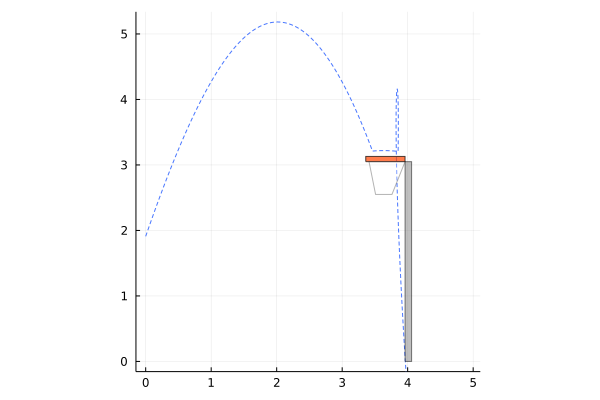

In [23]:
visualize_throw(sol, free_throw_line_x, 3000)

In [24]:
function animate_throw(distance, v₀, θ₀, h, t)
    rθ₀ = θ₀ / 180 * π  # [rad]

    x₀ = 0
    u₀ = [x₀; v₀ * cos(rθ₀); h; v₀ * sin(rθ₀)]
    tspan = range(0, stop=t, length=t*1000 + 1)
    sol = rungekutta4(basketball_throw, u₀, tspan);
    #sol = euler(basketball_throw, u₀, tspan)
    simulation = @animate for i ∈ 1:(t*1000 + 1)
                    visualize_throw(sol, distance, i)
                    scatter!( # ball
                            [sol[i, 1]], 
                            [sol[i, 3]], 
                            markersize=10, 
                            label="", 
                            color=:darkorange1
                            )
        end every 25
    return gif(simulation, "simulation.gif", fps = 40)
end

animate_throw (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\Marcin\Desktop\semestr III\Równania różniczkowe\ODE-project\simulation.gif
└ @ Plots C:\Users\Marcin\.julia\packages\Plots\vsE7b\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Marcin\\Desktop\\semestr III\\Równania różniczkowe\\ODE-project\\simulation.gif")
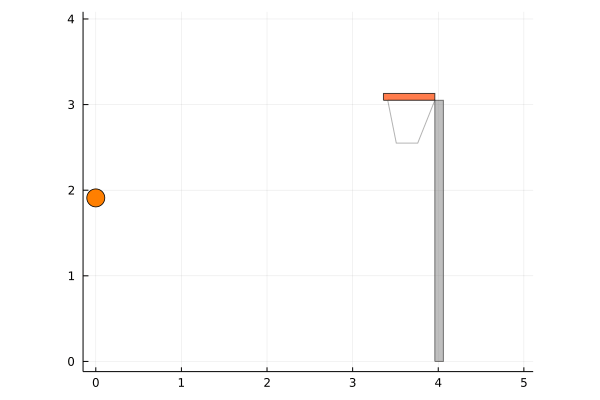

In [25]:
animate_throw(free_throw_line_x, 7.64, 44.58, 1.91, 2)

## Szukanie wartości początkowych v₀ i θ₀ dla których rzut jest celny - symulacja

Rzut celny: 

współrzędna y piłki ~= współrzędna y środka obręczy piłki

oraz

współrzędna x piłki ± margines błędu = współrzędna x środka obręczy

In [51]:
function rungekutta4_basic(f, y0, t)
    n = length(t)
    y = zeros((n, length(y0)))
    y[1,:] = y0
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(y[i,:], t[i])
        k2 = f(y[i,:] + k1 * h/2, t[i] + h/2)
        k3 = f(y[i,:] + k2 * h/2, t[i] + h/2)
        k4 = f(y[i,:] + k3 * h, t[i] + h)
        y[i+1,:] = y[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    end
    return y
end

rungekutta4_basic (generic function with 1 method)

In [71]:
findnearest(A::AbstractArray, t) = findmin(abs.(A.-t))
good_x(x::Number, distance::Number, ε::Number) = (x > distance - ε) &&  (x < distance + ε) ? true : false
good_y(y::Number, rim_y::Number, ε::Number) = (y > rim_y - ε) && (y < rim_y) ? true : false

good_y (generic function with 1 method)

In [72]:
function scored(sol, distance, rim_y, rim_diameter, ball_radius, x₀, ε)
    for point in zip(sol[:, 1], sol[:, 3])
        x, y = point[1], point[2]
        if good_x(x, distance - x₀ + rim_diameter/2, ε) && good_y(y, rim_y, ball_radius/2)
            return true
        end
    end
    return false
    end    

scored (generic function with 2 methods)

In [73]:
function throws_simulation(vₘᵢₙ, vₘₐₓ, θₘᵢₙ, θₘₐₓ, 
                            points, time, distance, 
                            players_height, ε;
                            x₀ = 0,
                            rim_y = 3.05,
                            ball_radius=0.11935, 
                            rim_diameter=0.46,
                            collisions=true,
                            ω₀ = 4π)
    
    good_v₀s = Array{Float64,1}()
    good_θ₀s = Array{Float64,1}()
    
    v₀s   = range(vₘᵢₙ, stop=vₘₐₓ, length=points)
    θ₀s   = range(θₘᵢₙ, stop=θₘₐₓ, length=points) ./ 180 .* π
    tspan = range(0,   stop=time, length=time*60)
    
    collisions ? solve = rungekutta4 : solve = rungekutta4_basic
    
    for θ₀ in θ₀s
        for v₀ in v₀s 
            u₀ = [x₀; v₀ * cos(θ₀); players_height; v₀ * sin(θ₀)] 
            global ω = ω₀
            sol = solve(basketball_throw, u₀, tspan)
            if scored(sol, distance, rim_y, rim_diameter, ball_radius, x₀, ε)
                push!(good_v₀s, v₀)
                push!(good_θ₀s, θ₀)
            end
        end
    end
    return good_v₀s, good_θ₀s ./ π .* 180
end

throws_simulation (generic function with 2 methods)

In [74]:
x, y = throws_simulation(5, 10, 30, 80, 200, 2, free_throw_line_x, 1.91, score_error, collisions=false)

([9.522613065326633, 9.547738693467336, 9.57286432160804, 9.597989949748744, 9.623115577889447, 9.64824120603015, 9.673366834170855, 9.698492462311558, 9.72361809045226, 9.748743718592964  …  9.899497487437186, 9.949748743718592, 9.974874371859297, 10.0, 9.899497487437186, 9.949748743718592, 9.974874371859297, 10.0, 9.949748743718592, 9.974874371859297], [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0  …  70.95477386934672, 70.95477386934672, 70.95477386934672, 70.95477386934672, 71.20603015075378, 71.20603015075378, 71.20603015075378, 71.20603015075378, 71.4572864321608, 71.4572864321608])

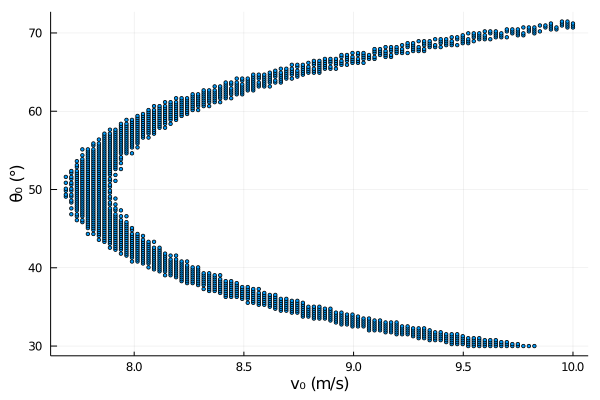

In [75]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="θ₀ (°)", label="")

In [76]:
x, y = throws_simulation(5, 10, 30, 80, 200, 2, free_throw_line_x, 1.91, score_error, collisions=true)

([9.72361809045226, 9.72361809045226, 9.72361809045226, 9.72361809045226, 9.72361809045226, 9.597989949748744, 9.22110552763819, 9.22110552763819, 9.371859296482413, 9.22110552763819  …  9.874371859296483, 9.899497487437186, 9.949748743718592, 9.974874371859297, 10.0, 9.874371859296483, 9.949748743718592, 9.974874371859297, 10.0, 9.949748743718592], [31.758793969849247, 32.01005025125628, 32.26130653266331, 32.51256281407035, 32.76381909547739, 33.015075376884425, 33.76884422110553, 34.02010050251256, 34.02010050251256, 34.2713567839196  …  70.95477386934672, 70.95477386934672, 70.95477386934672, 70.95477386934672, 70.95477386934672, 71.20603015075378, 71.20603015075378, 71.20603015075378, 71.20603015075378, 71.4572864321608])

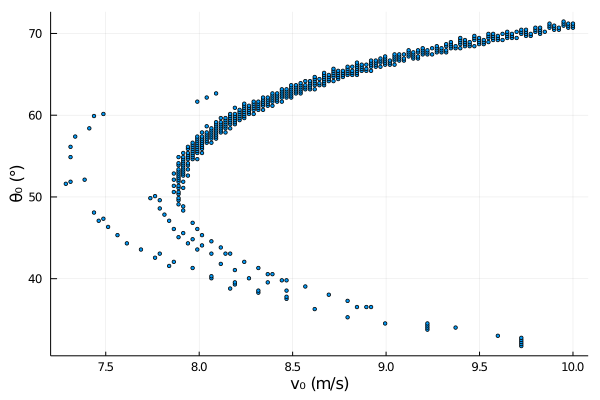

In [77]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="θ₀ (°)", label="")

# Symulacja dla ustalonego kąta i zmiennej prędkości kątowej

In [80]:
function throws_simulation2(vₘᵢₙ, vₘₐₓ, ωₘᵢₙ, ωₘₐₓ, 
                            points, time, distance, 
                            players_height, ε;
                            x₀ = 0,
                            rim_y = 3.05,
                            ball_radius=0.11935, 
                            rim_diameter=0.46,
                            collisions=true)
    
    good_v₀s = Array{Float64,1}()
    good_ω₀s = Array{Float64,1}()
    
    v₀s   = range(vₘᵢₙ, stop=vₘₐₓ, length=points)
    ω₀s   = range(ωₘᵢₙ, stop=ωₘₐₓ, length=100)
    tspan = range(0,   stop=time, length=time*60)
    collisions ? solve = rungekutta4 : solve = rungekutta4_basic
    
    for ω₀ in ω₀s
        for v₀ in v₀s 
            global ω = ω₀
            u₀ = [x₀; v₀ * cos(π/4); players_height; v₀ * sin(π/4)]
            sol = solve(basketball_throw, u₀, tspan)
            if scored(sol, distance, rim_y, rim_diameter, ball_radius, x₀, ε)
                push!(good_v₀s, v₀)
                push!(good_ω₀s, ω₀)
            end
        end
    end
    return good_v₀s, good_ω₀s
end

throws_simulation2 (generic function with 2 methods)

In [85]:
x, y = throws_simulation2(6, 9, 0, 20, 500, 2, free_throw_line_x, 1.91, score_error, collisions=false)

([7.917835671342686, 7.923847695390782, 7.929859719438878, 7.935871743486974, 7.94188376753507, 7.947895791583166, 7.953907815631262, 7.959919839679359, 7.965931863727455, 7.971943887775551  …  7.887775551102204, 7.8937875751503, 7.8997995991983965, 7.905811623246493, 7.9118236472945895, 7.917835671342686, 7.923847695390782, 7.929859719438878, 7.935871743486974, 7.94188376753507], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0])

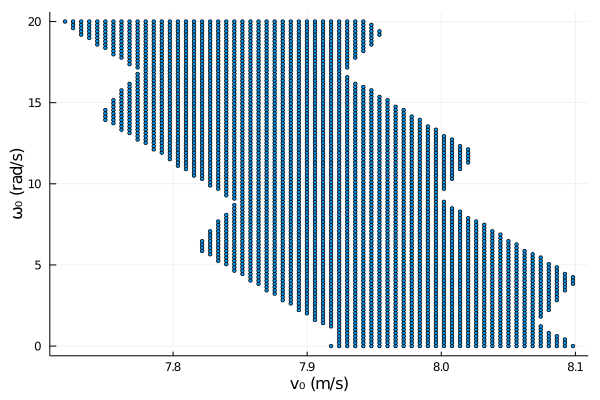

In [86]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="ω₀ (rad/s)", label="")